In [1]:
import pandas as pd
import numpy as np
from datetime import date
import psycopg2

import string
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
Rs = RussianStemmer()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [16]:
# Для первоначального запуска, далее не требуется
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
#Hive
host_name = "172.17.103.106"
port = 10000
user = "hue"
password = "hue"
database = "big_data"

conn = hive.Connection(host=host_name, port=port, username=user, password=password,
                           database=database, auth='CUSTOM')
cur = conn.cursor()

# TextMining для СУИ

In [2]:
df_query='''    
SELECT
    DATE(create_date) AS create_date,
    description
FROM 
    big_data.sui_data
WHERE 
    request_type="Предложения пользователей по улучшению портала"
GROUP BY
    DATE(create_date),
    description
HAVING
    COUNT(description)=1
ORDER BY 
    create_date
'''

In [ ]:
cur.execute('reset mapreduce.input.fileinputformat.split.maxsize')
cur.execute(df_query)
headers = [x[0] for x in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns = headers)
df['create_date'] = pd.to_datetime(df['create_date'])

In [3]:
df = pd.read_csv ('C:\\work_dfs\\2.Analytics_UV\\Tables\\hive_discriptions.csv', 
                  parse_dates=['create_date'])

In [4]:
df

create_date                                        description
0    2018-03-29  Здравствуйте. Есть ли у проекта мобильное прил...
1    2018-04-26  Здравствуйте, добавьте проблему "Отсутствие уб...
2    2018-04-27  \nЗашел на Ваш сайт хотел поделиться хорошими ...
3    2018-05-04  Здравствуйте, меня зовут Мария, 04.05.2018г. н...
4    2018-05-06  \nмое предложение- стеллу на площади Гайдара п...
..          ...                                                ...
97   2020-02-12  Добавьте как в Москве Пункт парковки на тротуа...
98   2020-02-17  Добрый день. Считаю что это неправильно, что н...
99   2020-02-18  Добрый день!\n\nПредлагаю вашей команде добави...
100  2020-02-19  Почему на сайте "Управляем вместе" нет вариант...
101  2020-02-25  \nДобрый вечер! Почему на сайте при голосовани...

[102 rows x 2 columns]

In [3]:
def tokenize_ru(file_text):
    # применяем nltk
    file_text = file_text.lower()
    tokens = word_tokenize(file_text)
    
    #подчищаем
    tokens = [i \
              .replace("«", "") \
              .replace("»", "") \
              .replace("\n", "") \
              .replace("\\n", "") \
              .replace("\\", "") \
              .replace("''", "") \
              .replace('``', "") \
              .replace('--', "") \
              .replace("/", "") for i in tokens]

    # удаляем пунктуацию
    tokens = [i for i in tokens if (i not in string.punctuation)]

    # удаляем stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', \
                       'на', '...','управляем','вместе','ru','n'])
    tokens = [i for i in tokens if (i not in stop_words)]
    
    # стемминг
    tokens = [Rs.stem(i) for i in tokens]
    
    # удаляем еще слова, после стемминга
    stop_words_after_stemming = ['добр','ден','permkrai','perm','program','mail','http','nhttp','mailto','nС','support', \
                                 'nДобрый','портал','сообщен','уважен','проблем','ответ','объект','https','мог','mail.ru',\
                                'permkrai.ru','сообщ','ваш','ошибк','отправл','дом','поч','дан','support-program',\
                                'работ','тем','пожалуйст','происход','уда','написа','здравствуйте','2019','город',\
                                'возможн','обращен','хотел','здравств', 'сдела', 'котор', 'проект', 'администрац', \
                                 'пункт','например','случа','друг', 'добав', '1', 'предложен', 'удобн', 'некотор',\
                                 'техническ','кра', 'спасиб', 'команд','пермск','очен', 'г.','здравствуйте.', 'поддержк',\
                                 'пробл', 'вопрос', 'поня', 'одн','20', 'прош', 'отсутств','так', 'повторн','он',\
                                 'жител','2','мо','александр', 'фот', 'т.к', 'врем','отправ','сво', 'мо','соответств',\
                                 'он', '41771','нескольк', 'отклон', 'счита','поп', 'един', 'участ', 'отвеча','важн',\
                                'нашл','приложен', 'сайт', 'порта', 'раздел',\
                                'мобильн', 'удач','программ', 'пермяк','написан','iphone', 'сохранен', 'либ',\
                                 'предлага', 'информац', 'тип', 'должн', 'сотрудник', 'яндекс.почт','треб', 'возника', 'реша',\
                                 'зашел','дорог','кнопк','остановк','письм','район','связа','категор','понятн','ответствен',\
                                 'снег','опубликова','модерац','zвечер','выезд','проблемн', 'убра','пользовател','решен',\
                                'прост','сторон','ям','вид', 'люд', 'евген','мест','эт', 'хот', 'текущ', '2018', 'может',\
                                 'обрат','част','созда','улиц','фотограф','нарушен','власт','момент', 'логинов', 'дела',\
                                'дмитр', 'хорош', 'прием', 'как', 'перм', 'частн', 'работа','реализова', 'нужн', 'движен',\
                                 'явля', 'ход', 'маршрут', 'оставля','продаж','ещ','вечер','тематик', 'гражданин','актуальн',\
                                 'обратн','развит','придомов','получа', 'стар', 'такж', 'заявк', 'связ', 'двор', 'будут',\
                                 'улучшен', 'госуслуг', 'запис', 'сам', 'полност', 'телефон','согласн', 'ввест', 'занима',\
                                 'газон', 'автомобил', 'прос','наход', 'невозможн', 'браузер', 'отключ', '06.10.2018', 'прям',\
                                 'www.gorodperm.rucitizenquestion', 'вдол', 'застройк', 'всем','долж', 'состоян', 'жизн',\
                                 '+05:00', 'процесс', 'орган','исполнительн', 'конечн', 'фотографирова', 'представител',\
                                 'regards', 'наркотик','голосован', 'наш','предлож', 'рубрик', 'дополнительн', 'выполнен',\
                                'содержан', 'качеств', 'вод','безналичн', 'оплат']
    tokens = [i for i in tokens if (i not in stop_words_after_stemming)]
    return tokens

In [4]:
def trans(str):
    mas = []
    for i in str:
        for k in i:
            mas.append(k)
    return mas

### Поиск самых популярных за все время (2018-2020)

In [5]:
# Добавляем столбец с токенами обращений
text = ' '.join(i for i in df['description'])
text = tokenize_ru(text)
freq = FreqDist(text)

In [6]:
def Replace(freq):
    kod = {'тротуар':'Тротуар',
           'чиновник':'Чиновник',
           'отписк':'Отписка',
           'парковк':'Парковка',
           'мусор':'Мусор',
           'уборк':'Уборка',
           'оценк':'Оценка',
           'дорожн':'Дорожный',
           'светофор':'Светофор',
           'знак':'Знак',
           'освещен':'Освещение',
           'авторизац':'Авторизация',
           'объявлен':'Объявление'}

    for i in freq:
        if i in kod:
            freq[kod[i]] = freq.pop(i)

    freq = freq.most_common()
    return freq

In [7]:
freq = Replace(freq)

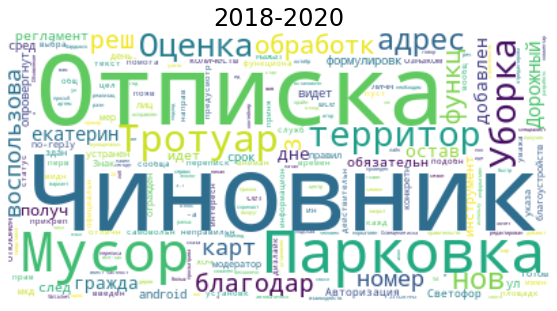

In [8]:
top = 5
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(freq))
plt.title("2018-2020",fontsize = 24)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Поиск самых популярных по годам

In [9]:
# Добавляем столбец с токенами обращений
df['tokenize'] = [tokenize_ru(i) for i in df['description']]

# Создаем функцию группировки
df1 = df.groupby(pd.Grouper(key="create_date", freq="Y"))['tokenize'].agg(list).reset_index()
df1.columns = ['create_date','tokenize']
df1['tokenize'] = [trans(i) for i in df1['tokenize']]
df1['freq'] = [Replace(FreqDist(i)) for i in df1['tokenize']]

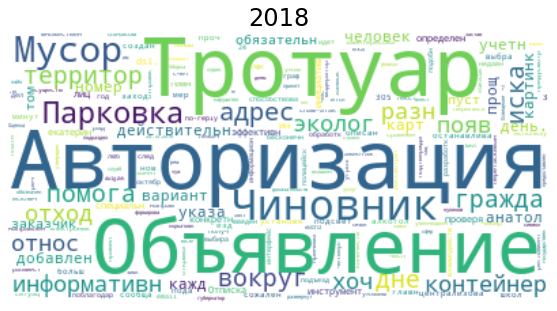

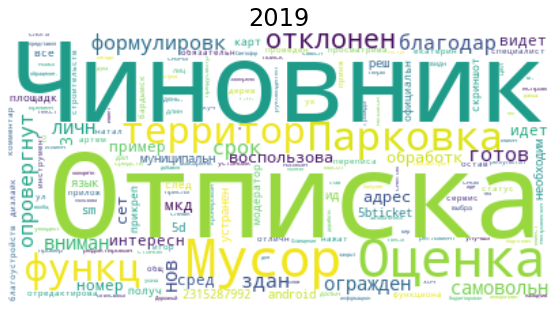

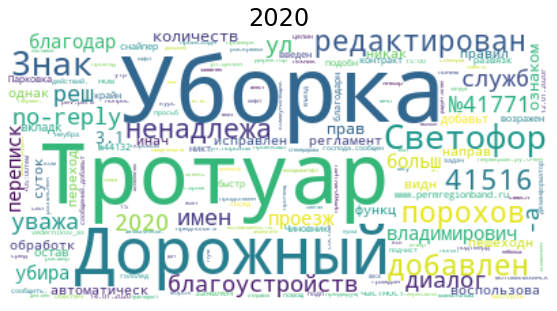

In [10]:
# отрисовка картинок
top = 5
for i,j in zip(df1.freq,df1.freq.index):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(i))
    plt.figure(figsize=(10,5))
    plt.title("{0}".format(df1.create_date[j].year),fontsize = 24)
    plt.imshow(wordcloud, interpolation='bilinear')    
    plt.axis("off")
    plt.show()

### Формирование гистограмм

In [11]:
top=5
fig = go.Figure()

fig.add_trace(go.Bar(
    name = '2018-2020',
    x = [i[0] for i in freq][:top],
    y = [i[1] for i in freq][:top]))

fig.add_trace(go.Bar(
    name = '2019',
    x = [i[0] for i in df1.freq[1]][:top],
    y = [i[1] for i in df1.freq[1]][:top]))

fig.add_trace(go.Bar(
    name = '2018',
    x = [i[0] for i in df1.freq[0]][:top],
    y = [i[1] for i in df1.freq[0]][:top]))

fig.add_trace(go.Bar(
    name = '2020',
    x = [i[0] for i in df1.freq[2]][:top],
    y = [i[1] for i in df1.freq[2]][:top]))

fig.update_layout(
    width=1000,
    height=600,
    title=dict(
        text='<b>Частота появления слов<b>',
        font=dict(
            size=25)),
    xaxis=dict(
        tickfont=dict(
            size=14)),
    yaxis=dict(
        tickfont=dict(
            size=14)),
    legend=dict(
        font=dict(
            size=20)),
    showlegend=True)
    
fig.show()

### Чистый текст сообщений (для себя)

In [12]:
def clear(df):
    df['clear_desc'] = [i \
          .replace("«", "") \
          .replace("»", "") \
          .replace("\n", "") \
          .replace("\\n", "") \
          .replace("\\", "") \
          .replace("''", "") \
          .replace('``', "") \
          .replace('--', "") \
          .replace("/", "") for i in df['description']]

    # удаляем пунктуацию
    df['clear_desc'] = [i for i in df['clear_desc'] if (i not in string.punctuation)]
    return df

In [12]:
def Find(df,word):
    df_quest = df[
        df['clear_desc'].str.contains(word)
        ].reset_index(drop=True)

    '''df_quest = df_quest[
        df_quest['create_date'].dt.year == 2018
        ].reset_index(drop=True)'''

    for i,n in zip(df_quest.create_date,df_quest.clear_desc):
        print('{0}\n{1}\n'.format(i,n)) 


# TextMining для Google Play

In [ ]:
df_google_play_query="""
select 
    goo_reviews.review_submit_date_and_time,
    goo_reviews.review_text
from 
    big_data.goo_reviews
"""

In [ ]:
cur.execute('reset mapreduce.input.fileinputformat.split.maxsize')
cur.execute(df_google_play_query)
headers = [x[0] for x in cur.description]
data = cur.fetchall()
df_google_play = pd.DataFrame(data, columns = headers)
df_google_play.columns = ['create_date','description']
df_google_play['create_date'] = pd.to_datetime(df_google_play['create_date'])

In [19]:
#csv
df_google_play = pd.read_csv(
    'C:\\Users\\Acer\\Desktop\\work_dfs\\Portal-analytics\\Tables\\SUI_google_play_desc.csv',
    usecols = ['goo_reviews.review_submit_date_and_time','goo_reviews.review_text'],
    parse_dates=['goo_reviews.review_submit_date_and_time'])

df_google_play.columns = ['create_date','description']

In [20]:
# Удаляем строки с пропусками
df_google_play = df_google_play.dropna().reset_index(drop=True)

In [21]:
#Классифицируем по типу обращения
df_google_play['type_quest']=[
    1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,3,3,2,2,
    1,3,2,2,1,2,2,2,3,2,
    3,1,1,1,1,1,1,1,1,2,
    1,3,1,2,1,2,1,1,3,3,
    2,2,2,1,3,2,2,2,2,2,
    1,1,3,2,2,2,2,1,1,1,
    1,1,2,1,2,1,1,1,1,2,
    2,2]

kod = {1:'заявки по неработоспособности портала',
       2:'обращение',
       3:'предложения пользователей по улучшению портала',
       4:'спам',
       5:'тест'}

df_google_play['type_quest'] = df_google_play['type_quest'].apply(lambda x: kod[x])

In [22]:
#Выбираем только "предложения пользователей по улучшению портала"
df_google_play=df_google_play[
    df_google_play['type_quest']=='предложения пользователей по улучшению портала'].reset_index(drop=True)

In [24]:
df_google_play.create_date.size

10

In [23]:
top=5
fig = go.Figure()

fig.add_trace(go.Bar(
    x = ['Функционал как на портале',
         'Одновременное добавление<br>нескольких фото',
         'Возможность редактировать<br>сообщение-заявку',
         'Оценки действий служб',
         'Оформление',
         'Возможность просмотра<br>документации по объектам'],
    y = [2,2,2,2,1,1]))

fig.update_layout(
    width=1000,
    height=600,
    title=dict(
        text='<b>Классификация предложений<br>по улучшению мобильного приложения Google Play</b><br>июнь 2019 - октябрь 2019',
        font=dict(
            size=17)),
    xaxis=dict(
        title='Содержание сообщений',
        tickfont=dict(
            size=16)),
    yaxis=dict(
        title='Кол-во сообщений',
        tickfont=dict(
            size=16)),
    showlegend=False)
    
fig.show()

# TextMining для App Store

In [25]:
#csv
df_app_store = pd.read_excel(
    'C:\\Users\\Acer\\Desktop\\work_dfs\\Portal-analytics\\Tables\\ЗаявкиAppStore.xlsx',
    parse_dates=['Дата создания','Дата ответа'])
df_app_store.columns = ['create_date','description','type_quest','closing_date']

kod = {1:'заявки по неработоспособности портала',
       2:'обращение',
       3:'предложения пользователей по улучшению портала',
       4:'спам',
       5:'тест'}

df_app_store['type_quest'] = df_app_store['type_quest'].apply(lambda x: kod[x])
df_app_store=df_app_store.sort_values(by='create_date').reset_index(drop=True)

In [26]:
#Выбираем только "заявки по неработоспособности портала"
df_app_store=df_app_store[df_app_store['type_quest']=='предложения пользователей по улучшению портала']

In [27]:
df_app_store

create_date                                        description  \
3   2019-05-06  Прикрутите сжималку картинок, иначе с нормальн...   
5   2019-05-17  Вопрос- а видео с проблемой можно как-то загру...   
8   2019-06-26  Не хватает удаления фотографий, а так не плохо...   
17  2019-08-11  Спасибо за приложение, жаль нельзя видео добав...   
22  2020-01-21  Хотелось бы иметь возможность ставить отметку ...   

                                        type_quest closing_date  
3   предложения пользователей по улучшению портала   2019-05-21  
5   предложения пользователей по улучшению портала          NaT  
8   предложения пользователей по улучшению портала          NaT  
17  предложения пользователей по улучшению портала          NaT  
22  предложения пользователей по улучшению портала          NaT

In [28]:
df_app_store.create_date.size

5